## Modelaje de tópicos de Tweets

### Obtención de datos

Se corren inicialmente las librerías necesarias para el programa, dentro de este apartado se encuentra $snscrape$ el cual es una librería proveniente de un github, es necesario instalar dicho repositorio para poder correr la librería. Aunque de igual forma, en caso de carecer de alguna librería, correr el siguiente comando de $pip$ $install$ (libreria)

In [1]:
pip install snscrape

Note: you may need to restart the kernel to use updated packages.


In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tweepy
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Se realiza el scraping en la red social de Twitter para obtener los Tweets, con los siguientes parámetros:
- Cuenta: BanorteEscucha
- Desde: 2021-06-01 (6 de Junio de 2021)
- Hasta: 2022-06-01 (6 de Junio de 2022)

In [3]:
atributos =[]

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('@BanorteEscucha since:2021-06-01 until:2022-06-01').get_items()):
    atributos.append([tweet.user.username, tweet.user.displayname,tweet.date, tweet.content,tweet.user.location])
    
# Creamos df con los atributos deseados
tweets_df = pd.DataFrame(atributos, columns=["Nombre de usuario",'Nombre', "Fecha", "Tweet",'Ubicacion'])

C:\Users\resen\AppData\Local\Temp\ipykernel_7868\683037763.py:4: FutureWarning: content is deprecated, use rawContent instead
  atributos.append([tweet.user.username, tweet.user.displayname,tweet.date, tweet.content,tweet.user.location])


KeyboardInterrupt: 

Una vez generado el Data Frame mostramos la información obtenida

In [ ]:
tweets_df.head()

,Nombre de usuario,Nombre,Fecha,Tweet,Ubicacion
0,pekinoxio,J. MarS,2022-05-31 23:58:03+00:00,"@BanorteEscucha No me han atendido por MD, tie...",
1,HectorMorenoMtz,Héctor Moreno Mtz.,2022-05-31 23:07:46+00:00,¡Hola @Banorte_mx @BanorteEscucha ! Desde ayer...,
2,AimeeLara19,Aimee Lara,2022-05-31 23:03:44+00:00,@RockndRollas @BanorteEscucha Igual,"Coahuila de Zaragoza, México"
3,BanorteEscucha,BANORTE,2022-05-31 22:39:01+00:00,@pekinoxio Con gusto continuaremos la atención...,México
4,pekinoxio,J. MarS,2022-05-31 22:38:17+00:00,@BanorteEscucha Ya lo envíe,


### Análisis de datos

#### Variables

El siguiente apartado contiene los modulos con gran tamaño de memoria usadas en este apartado, incluyendo diccionarios, clases, funciones:

In [ ]:
dic_users_1 = {'.*(brasil|japon|panama|uito|philadelphia|texas|venezuela|chile|seattle|serbia|dinamar|usa|new york|nueva york|nigeria|us|berlin|madrid|las vegas|venezuela|michigan|milan|east vinewood|england|houston|denmark|el paso|dinamarca|city ireland|irlanda|tx|united states|calida|california|colombia|brooklyn|belgica|buenos aires|argentina|barcelona|espanyol|british columbia|washington|alemania).*':r'otro pais',
              '.*(lerma|texcoco|metepec|iztatla|calimaya|calixtlahuaca|zacazonapan|rio juarez|villa del carbon|toluquita|toluca|edomex|ecatepec|edo.*xico|estado.*mexico|naucalpan|estado de mexico|edo mex).*': 'estado de mexico',
              '.*(cerro.*silla|san.*colas|sant esteve|ser fiera|santa catarina|regio|noreste|mty|apodaca|gustavo|las aguilas|leon|norte|monterrey|mtymx|nuevo leon|onterrey|monterrey).*': 'monterrey',
              '.*(guadalajara|jalisco|gdl|guadalajara|zapopan|tapatilandia).*': 'guadalajara',
              '.*(puebla|pue|capu11|tehuacan).*':'puebla',
              '.*(aculco|acapulco|ejido viejo).*':'acapulco',
              '.*(guanajuato|cervantina|gto|memejuato|irapuato).*': 'guanajuato',
              '.*(aguascalientes|ags).*':'aguascalientes',
              '.*(jaroch|veracruz|xalapa|alvarado veracruz de ignacio).*':'veracruz',
              '.*(zacatecas|zac).*':'zacatecas',
              '.*(chiapas|tuxtla|chiapanese|san cristobal).*':'chiapas',
              '.*(coahuila|saltillo|torreon|saltirock|saltiyork).*':'coahuila',
              '.*(morelos|cuernavaca).*':'morelos',
              '.*(culiacan|sinaloa|culichi|sinaloense).*':'culiacan',
              '.*(cabo san|baja calif|mexicali|baja california|ensenada|los cabos|tijuana|la paz).*':'baja california',
              '.*(tabasco|villahermosa|tabasco).*':'tabasco',
              '.*(sonora|hermosillo|cerro.*campana|nogales).*':'sonora',
              '.*(hidalgo|pachuca|mochiteco).*':'hidalgo',
              '.*(merida|yucatan|cancun|merida).*':'merida',
              '.*(san luis potosi|san pedro|slp.*).*':'san luis potosi',
              '.*(nayarit).*':'nayarit',
              '.*(oaxaca|huajuapan).*':'oaxaca',
              '.*(queretaro|cadereyta|qro|quereraro|ueretaro).*':'queretaro',
              '.*(quintana|caribe|tulum).*':'quintana roo',
              '.*(tampico|tamaulipas|cd victoria|tamaulipeca|matamoros|nuevo laredo).*':'tamaulipas',
              '.*(chihuahua|cd juarez|juarez).*':'chihuahua',
              '.*(durango|lerdo).*':'durango',
              '.*(michoacan|morelia|zitacuaro).*':'michoacan',
              '.*(campeche|mundo maya).*': 'campeche',
              '.*(tlaxcala).*':'tlaxcala',
              '.*(metropolitana|atizapan|unam|tlalpan|xochimilco|chapultepec|reynoaventura|roma|gustavo a mader|balderas|m/x|macross|chilanga|iztapalapa|messico|mejico|coyoacan|cuerna|cd mexico|universidad nacional autonoma|villamelon|castillo|noches tristes|municipal|buenavista|benito juarez|arcos|aragon|vagabundo|nueva galicia|alvaro obregon|anahuak|alameda|poco d ai|#cuu|cuajimalpa|gran pais|mx|tenochtitlan|ciudad capital|mex-|manzanillo|senado|ciudad.*co|distrito|cd*ico|de efe|df|ciudad|mex.*ity|(mexico md)|(mexico me)|(^mx$)|🇲🇽|cdmx|cd de mexico|chilango|mexico.*jaguar|av insurgentes|m e x i c o|mexico|cu|d f).*': 'cdmx',
              '':'nan'}

dic_users_2 = {r'.*(japon|brasil|panama|uito|philadelphia|texas|venezuela|chile|seattle|serbia|dinamar|usa|new york|nueva york|nigeria|las vegas|venezuela|michigan|milan|east vinewood|england|houston|denmark|el paso|dinamarca|city ireland|irlanda|tx|united states|calida|california|colombia|brooklyn|belgica|buenos aires|argentina|barcelona|espanyol|british columbia|washington|alemania).*':r'otro pais',
              r'.*(toluca|estado de mexico|ecatepec|cuautitlan|tultitlan|edomex|ixtapaluca|edo mex).*': r'estado de mexico',
              r'.*(.*(cdmx).*|homero|ciudad de mexico|ciudad|(\sdf\s)|patriotismo|acoxpa|tlalpan|san angel|villas de la hacienda|zona industrial|ajusco|san jose del cabo|san carlos metepec|bosques de la victoria|necaxa|polyforum|toreo|reforma|lindavista|azcapotzalco|\scdmx\s|plazasatelite).*': r'cdmx',
              r'.*(monterrey|(\smty\s)|mty|nuevoleon).*': r'monterrey',
              r'.*(guadalajara|jalisco|gdl).*': r'guadalajara',
              r'.*(puebla).*':r'puebla',
              r'.*(acapulco|ejido viejo).*':r'acapulco',
              r'.*(guanajuato|cervantina|gto|memejuato|irapuato|(\sgto\s)).*': r'guanajuato',
              r'.*(aguascalientes|(\sags\s)).*':r'aguascalientes',
              r'.*(jaroch|veracruz|xalapa|alvarado veracruz de ignacio).*':r'veracruz',
              r'.*(zacatecas|(\szac\s)).*':r'zacatecas',
              r'.*(chiapas|tuxtla|chiapanese|san cristobal|(\schis\s)).*':r'chiapas',
              r'.*(coahuila|saltillo|torreon|saltirock|saltiyork).*':r'coahuila',
              r'.*(morelos|cuernavaca).*':r'morelos',
              r'.*(culiacan|sinaloa|culichi|sinaloense).*':r'culiacan',
              r'.*(cabo san|baja calif|mexicali|baja california|ensenada|los cabos|tijuana|la paz).*':r'baja california',
              r'.*(tabasco|villahermosa|tabasco).*':r'tabasco',
              r'.*(sonora|hermosillo|cerro.*campana|nogales).*':r'sonora',
              r'.*(hidalgo|pachuca|mochiteco|(\shgo\s)).*':r'hidalgo',
              r'.*(merida|yucatan|cancun|merida|ermita).*':r'merida',
              r'.*(san luis potosi|san pedro|(\sslp\s)|potosina|#slp).*':r'san luis potosi',
              r'.*(nayarit).*':r'nayarit',
              r'.*(oaxaca|huajuapan|(\soax\s)).*':r'oaxaca',
              r'.*((\sqro\s)|queretaro|cadereyta|qro|quereraro|ueretaro).*':r'queretaro',
              r'.*(quintana|tulum|caribe).*':r'quintana roo',
              r'.*(tampico|tamaulipas|cd victoria|tamaulipeca|matamoros|nuevo laredo).*':r'tamaulipas',
              r'.*(chihuahua|cd juarez).*':r'chihuahua',
              r'.*(durango|lerdo).*':r'durango',
              r'.*(michoacan|morelia|zitacuaro).*':r'michoacan',
              r'.*(campeche|mundo maya).*': r'campeche',
              r'.*(tlaxcala).*':r'tlaxcala'}

dic_users_3 = {r'.*(panama|uito|philadelphia|texas|venezuela|chile|seattle|serbia|dinamar|usa|new york|nueva york|nigeria|las vegas|venezuela|milan|east vinewood|england|houston|denmark|el paso|dinamarca|city ireland|irlanda|tx|united states|calida|california|colombia|brooklyn|belgica|buenos aires|argentina|barcelona|espanyol|british columbia|washington|alemania).*':r'otro pais',
              r'.*(toluca|estado de mexico|ecatepec|cuautitlan|tultitlan|edomex|ixtapaluca|edo mex|lerma|metepec|iztatla|calimaya|calixtlahuaca|zacazonapan|rio juarez|villa del carbon|toluca|edomex|ecatepec|edo.*xico|estado.*mexico|naucalpan|estado de mexico).*': r'estado de mexico',
              r'.*(.*(cdmx).*|palacio nacional|homero|ciudad de mexico|ciudad|(\sdf\s)|patriotismo|acoxpa|tlalpan|san angel|villas de la hacienda|zona industrial|ajusco|san jose del cabo|san carlos metepec|bosques de la victoria|necaxa|polyforum|toreo|lindavista|azcapotzalco|\scdmx\s|plazasatelite|metropolitana|atizapan|unam|tlalpan|xochimilco|chapultepec|reynoaventura|roma|gustavo a mader|balderas|m e x i c o|m.xico|m/x|macross|chilanga|iztapalapa|messico|mejico|coyoacan|cuerna|cd mexico|universidad nacional autonoma|villamelon|castillo|noches tristes|municipal|buenavista|benito juarez|arcos|aragon|vagabundo|nueva galicia|alvaro obregon|mex|anahuak|alameda|poco d ai|#cuu|cuajimalpa|gran pais|mx|mexico|tenochtitlan|ciudad capital|mex-|manzanillo|senado|ciudad.*co|distrito|cd*ico|de efe|df|ciudad|(^mexico$)|mex.*ity|(mexico md)|(mexico me)|(^mx$)|🇲🇽|cdmx|cd de mexico|chilango|mexico.*jaguar|av insurgentes|unam).*': r'cdmx',
              r'.*(monterrey|(\smty\s)|mty|nuevoleon|cerro.*silla|san.*colas|sant esteve|ser fiera|santa catarina|regio|noreste|mty|apodaca|gustavo|las aguilas|leon|norte|monterrey|mtymx|nuevo leon|onterrey|monterrey).*': r'monterrey',
              r'.*(guadalajara|jalisco|gdl|guadalajara|zapopan|tapatilandia).*': r'guadalajara',
              r'.*(puebla|pue|capu11).*':r'puebla',
              r'.*(aculco|acapulco|ejido viejo).*':r'acapulco',
              r'.*(guanajuato|cervantina|gto|memejuato|irapuato).*': r'guanajuato',
              r'.*(aguascalientes|ags).*':r'aguascalientes',
              r'.*(jaroch|veracruz|xalapa|alvarado veracruz de ignacio).*':r'veracruz',
              r'.*(zacatecas|zac).*':r'zacatecas',
              r'.*(chiapas|tuxtla|chiapanese|san cristobal).*':r'chiapas',
              r'.*(coahuila|saltillo|torreon|saltirock|saltiyork).*':r'coahuila',
              r'.*(morelos|cuernavaca).*':r'morelos',
              r'.*(culiacan|sinaloa|culichi|sinaloense).*':r'culiacan',
              r'.*(cabo san|baja calif|mexicali|baja california|ensenada|los cabos|tijuana|la paz).*':r'baja california',
              r'.*(tabasco|villahermosa|tabasco).*':r'tabasco',
              r'.*(sonora|hermosillo|cerro.*campana|nogales).*':r'sonora',
              r'.*(hidalgo|pachuca|mochiteco).*':r'hidalgo',
              r'.*(merida|yucatan|cancun|merida).*':r'merida',
              r'.*(san luis potosi|san pedro|slp.*).*':r'san luis potosi',
              r'.*(nayarit).*':r'nayarit',
              r'.*(oaxaca|huajuapan).*':r'oaxaca',
              r'.*(queretaro|cadereyta|qro|quereraro|ueretaro).*':r'queretaro',
              r'.*(quintana|caribe).*':r'quintana roo',
              r'.*(tampico|tamaulipas|cd victoria|tamaulipeca|matamoros|nuevo laredo).*':r'tamaulipas',
              r'.*(chihuahua|cd juarez|juarez).*':r'chihuahua',
              r'.*(durango|lerdo).*':r'durango',
              r'.*(michoacan|morelia|zitacuaro).*':r'michoacan',
              r'.*(campeche|mundo maya).*': r'campeche',
              r'.*(tlaxcala).*':r'tlaxcala'}

In [ ]:
class analisis_datos:
    def __init__(self,df):
        self.tweets = df
    def conteo_tweets(self):
        conteo = self.tweets.groupby('Nombre de usuario', as_index=False).count()
        conteo = conteo[conteo["Nombre de usuario"].str.contains("Banorte") == False]
        conteo = conteo.nlargest(20,'Tweet')
        sns.barplot(data = conteo, x=conteo['Tweet'],y=conteo['Nombre de usuario'],palette='rocket')
        plt.show()
        print(conteo.head())
    def tweets_no_banorte(self):
        tw_tm = self.tweets.drop(tweets_df[self.tweets['Nombre de usuario'] == 'BanorteEscucha'].index, inplace=False)
        tw_tm = tw_tm.fillna('nan')
        return(tw_tm)
    def conversion_fecha(self,fecha):
        fecha=fecha.apply(lambda x: datetime.strftime(x,'%y/%m/%d'))
        fecha=fecha.apply(lambda x: datetime.strptime(x,'%y/%m/%d'))
        return fecha
    def dias_ts(self,df,df2):
        dia = df['Fecha'].groupby(df['Fecha'].dt.floor('d')).size().reset_index(name='count')
        dia2 = df2['Fecha'].groupby(df2['Fecha'].dt.floor('d')).size().reset_index(name='count')
        dia['Tweet p/dia'] = dia['count']
        dia2['Tweet p/dia banorte'] = dia2['count']
        dia=dia.drop(columns=['count'])
        dia2=dia2.drop(columns=['count'])
        df_join=pd.merge(dia,dia2,how='inner',on=['Fecha'])
        df_join = df_join.set_index('Fecha')
        plt.figure(figsize=(16,8),dpi=200)
        df_join.plot(label='Tweets',color=['purple','pink'])
        plt.title('Tweets')
        plt.xlabel('Fecha')
        plt.legend()
        return(df_join)
    def eliminacion_caracteres(self,columna):
        #caracteres especiales
        columna = columna.map(lambda x: re.sub('[,\.!?@]', '', x))
        # minusculas
        columna = columna.map(lambda x: x.lower())
        #acentos
        columna = columna.map(lambda x: re.sub('á', r'a', x))
        columna = columna.map(lambda x: re.sub('é', r'e', x))
        columna = columna.map(lambda x: re.sub('í', r'i', x))
        columna = columna.map(lambda x: re.sub('ó', r'o', x))
        columna = columna.map(lambda x: re.sub('ú', r'u', x))
        return columna
    def sustitucion(self,columna,diccionario):
        return(columna.apply(lambda x: x.replace(diccionario, regex=True)))
    def sustitucion_contenido(self,df):
        df = df.apply(lambda x: x.replace(dic_users_2, regex=True))
        for i in df['Tweet'].index:
            for k,v in dic_users_1.items():
                if v in df['Tweet'][i]:
                    df['Ubicacion'][i]=v
        return df
    def sustitucion_tweets(self,df,columna,diccionario):
        columna = columna.apply(lambda x: x.replace(diccionario, regex=True))
        df['Ubicacion'] = 'nan'
        for i in df['Tweets'].index:
            for k,v in diccionario.items():
                if v in df['Tweets'][i]:
                    df['Ubicacion'][i] = v
        print(columna)
        return(df) 
    def sustitucion_tweets_users(self,df,columna,dic_users_3):
        columna = columna.apply(lambda x: x.replace(dic_users_3, regex=True))
        df['Ubicacion'] = 'nan'
        for i in df['Tweets'].index:
            for k,v in dic_users_3.items():
                if v in columna['Tweets'][i]:
                    df['Ubicacion'][i] = v
        return(df)
    def sustitucion_tweets_nan(self,tw_temp,usuarios_nan):
        usuarios_nan['Ubicacion'] = usuarios_nan['Ubicacion'].replace(r'^nan$',np.nan,regex=True)
        usuarios_nan = usuarios_nan.dropna()
        usuarios_nan = usuarios_nan.drop_duplicates(subset='Username',keep='first')

        for word in usuarios_nan['Username'].index:
            tw_temp.loc[tw_temp['Nombre de usuario'] == usuarios_nan['Username'][word],'Ubicacion'] = usuarios_nan['Ubicacion'][word]
        return(tw_temp)
    def sustitucion_df(self,df,tw_tm):
        cond = df['Ubicacion']!='nan'
        df = df.where(cond)
        df = df.dropna()
        
        for word in df['Nombre de usuario'].index:
            tw_tm.loc[tw_tm['Nombre de usuario'] == df['Nombre de usuario'][word],'Ubicacion'] = df['Ubicacion'][word]
        return (tw_tm)
    def busqueda_tweets_user(self,df,tw_tm):
        df = tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]
        df = df.groupby('Nombre de usuario',as_index=False).count()
        df = list(df['Nombre de usuario'])
        
        usuarios_nan=[]

        for j in df:
            try:
                for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:' + j).get_items()):
                    if i>15:
                        break
                    usuarios_nan.append([tweet.user.username,tweet.content])
            except snscrape.base.ScraperException:
                usuarios_nan.append([j,'No permisos'])
        return pd.DataFrame(usuarios_nan, columns=['Username', "Tweets"])
    def tweets_ubi_desc(self, tw_tm, diccionario):
        tw_ubi = pd.merge(tw_tm,pd.DataFrame(dic_users_1.values(), columns=['Ubicacion']), on='Ubicacion',how = 'left',indicator=True)
        ej = tw_ubi.loc[tw_ubi['_merge'] == 'left_only', 'Ubicacion']
        ej2 = tw_tm[tw_tm['Ubicacion'].isin(ej)]
        return(ej2)
    def df_final(self, tw_tm, diccionario):
        tw_ubi = pd.merge(tw_tm,pd.DataFrame(dic_users_3.values(), columns=['Ubicacion']), on='Ubicacion',how = 'left',indicator=True)
        ej = tw_ubi.loc[tw_ubi['_merge'] == 'both', 'Ubicacion']
        ej2 = tw_tm[tw_tm['Ubicacion'].isin(ej)]
        return(ej2)

#### Analisis de tweets globales

Se asigna a la variable **analisis** la clase de análisis de tweets para operar sobre los tweets totales

In [ ]:
analisis = analisis_datos(tweets_df)

Se tiene una variable, DataFrame que contiene tweets con los siguientes atributos
- Nombre de Usuario
- Apodo del usuario
- Fecha del tweet
- Contenido del tweet
- Ubicación del usuario del tweet

Ahora bien, se analizan los usuarios con mayor número de tweets de la siguiente forma:

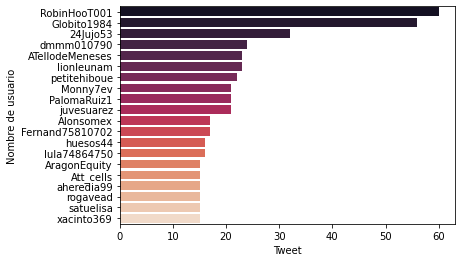

     Nombre de usuario  Nombre  Fecha  Tweet  Ubicacion
2090      RobinHooT001      60     60     60         60
964        Globito1984      56     56     56         56
14            24Jujo53      32     32     32         32
3215        dmmm010790      24     24     24         24
72     ATellodeMeneses      23     23     23         23


In [ ]:
analisis.conteo_tweets()

En general, no existe contenido vacío por parte del usuario con más tweets realizados, sin embargo esto no se puede asumir para todos los usuarios restantes. 

Siguiendo el análisis, se analizará el número de tweets realizados por día tanto por parte de los usuarios como por parte de la cuenta de BanorteEscucha, antes de realizar dicho gráfico asignamos a la variable **tw_tm** los tweets realizados por usuarios ajenos a la cuenta de Banorte, esto para la realización y análisis del modelo de tópicos. Por otro lado, la variable **banorte_tweets** contiene los tweets realizados por la cuenta BanorteEscucha

In [ ]:
tw_tm = analisis.tweets_no_banorte()
banorte_tweets = tweets_df[~tweets_df.isin(tw_tm)].dropna()

El gráfico de serie de tiempo en comparación de ambos tweets queda de la siguiente manera:

<Figure size 3200x1600 with 0 Axes>

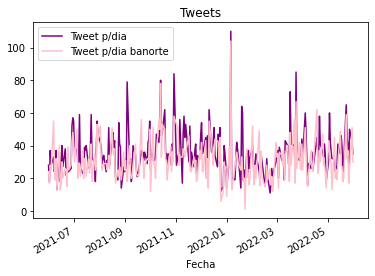

In [ ]:
tw_tm['Fecha'] = analisis.conversion_fecha(tw_tm['Fecha'])
banorte_tweets['Fecha'] = analisis.conversion_fecha(banorte_tweets['Fecha'])
tweets = analisis.dias_ts(tw_tm,banorte_tweets)

De forma descriptiva/numérica:

In [ ]:
tweets.describe()

,Tweet p/dia,Tweet p/dia banorte
count,255.000000,255.000000
mean,35.184314,30.721569
std,13.711070,12.614395
min,11.000000,1.000000
25%,26.000000,22.500000
50%,34.000000,28.000000
75%,41.000000,37.000000
max,110.000000,104.000000


Como se observa, la tendencia de tweet/respuesta por parte de usuario/compañía es prácticamente el mismo. Conteniendo una media básicamente igual, y en el punto alto, **6/enero/2022**, se tiene un número igual de tweets realizados. Esto habla sobre la tendencia de contestar las quejas/dudas/comentarios por parte del público acerca de los productos/servicios por parte de Banorte y la atención completa que presenta.

#### Análisis de tweets externos a Banorte

Se procede a realizar un análisis sobre los tweets de los usuarios, llamado con la variable **tw_tm**, especialmente en la ubicación de los tweets. Inicialmente se cuenta con la siguiente información de ubicaciones:

In [ ]:
analisis = analisis_datos(tweets_df)

In [ ]:
tw_tm.groupby('Ubicacion').count()

,Nombre de usuario,Nombre,Fecha,Tweet
Ubicacion,,,,
,3878,3878,3878,3878
,5,5,5,5
(っ˘ڡ˘ς) Te sigue,2,2,2,2
Ciudad de México,2,2,2,2
Mexico,1,1,1,1
...,...,...,...,...
🐰,1,1,1,1
💫,2,2,2,2
📍GDL / CDMX / MTY,2,2,2,2


Se observa que se cuenta con 1481 Ubicaciones, sin embargo, esto no puede ser posible, además que se tienen repeticiones y errores gramaticales y ortográficos de lugares como *CDMX*, *Monterrey*, *Guadalajara*, etc. Para resolver este problema se sustituyen los lugares usando herramientas de expresiones regulares, **REGEX**.

De primer instancia, se sustituyen los caracteres especiales, acentos, mayusculas a minúsculas, etc.

In [ ]:
tw_tm['Ubicacion'] = analisis.eliminacion_caracteres(tw_tm['Ubicacion'])

Ahora, se aplica el diccionario que contiene las *REGEX*, con nombre de **dic_users_1**.

In [ ]:
tw_tm['Ubicacion'] = analisis.sustitucion(pd.DataFrame(tw_tm['Ubicacion']),dic_users_1)

Chequemos nuevamente el número de estados agrupándolos, obteniendo el siguiente resultado

In [ ]:
tw_tm.groupby('Ubicacion').count()

,Nombre de usuario,Nombre,Fecha,Tweet
Ubicacion,,,,
,5,5,5,5
(っ˘ڡ˘ς) te sigue,2,2,2,2
wwwcreamfinancecom,1,1,1,1
#ss_area51,2,2,2,2
06500,2,2,2,2
...,...,...,...,...
𝕴𝖓 𝖞𝖔𝖚𝖗 𝖑𝖆𝖕𝖙𝖔𝖕,1,1,1,1
🌑,1,1,1,1
🐰,1,1,1,1


Tal como observamos, baja considerablemente el número de lugares registrados por usuarios, sin embargo, el número de tweets con usuarios sin ubicación registrada aún sigue siendo alto, existe otra forma de reducir dicho número.

Analizando el contenido del tweet por si menciona alguna ubicación y sustituyendo el valor en la columna *Place*.

Iniciamos seleccionando aquellos usuarios con ubicación *nan*

In [ ]:
user_nan = tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]

Eliminamos caracteres especiales, acentos, mayúsculas, etc:

In [ ]:
user_nan['Tweet'] = analisis.eliminacion_caracteres(user_nan['Tweet'])

C:\Users\resen\AppData\Local\Temp\ipykernel_10540\1116600906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_nan['Tweet'] = analisis.eliminacion_caracteres(user_nan['Tweet'])


Se realiza la busqueda y sustitución de ubicaciones correspondientes a las *REGEX* contenidas en **dic_users_2** y sustituyen los valores que fueron asignados de forma erronea, ya que se analizaron los tweets pero se sustituye toda columna en el DataFrame.

In [ ]:
user_nan = analisis.sustitucion_contenido(user_nan)

user_nan['Tweet'],user_nan['Nombre de usuario'], user_nan['Nombre'] = pd.DataFrame(tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]['Tweet']),pd.DataFrame(tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]['Nombre de usuario']),pd.DataFrame(tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]['Nombre'])

C:\Users\resen\AppData\Local\Temp\ipykernel_10540\3978677751.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ubicacion'][i]=v


Se procede a sustituir los valores que están en el DataFrame original, **tw_tm**

In [ ]:
tw_tm = analisis.sustitucion_df(user_nan,tw_tm)

Realizamos nuevamente el conteo de estados

In [ ]:
ej = tw_tm.groupby('Ubicacion', as_index=False).count()

De igual forma, baja considerablemente el número de ubicaciones *nan*, existe inclusive otra forma en la que se puedan bajar dicho número de tweets sin ubicación. Analizando los tweets publicados por cada usuario y realizar una busqueda de ubicaciones publicadas en dichos posts. 

La metodología de sustitución es análoga a la pasada. Sin embargo, hace falta buscar los primeros 15 tweets por usuario (en caso de ser posible, ya que algunos usuarios tienen restringidos sus cuentas), analizar cada tweet y sustuir basándose en el diccionario **dic_users_3**.

Realizando el primer paso, obtención de tweets por usuario, queda de la siguiente forma:

In [ ]:
usuarios_nan = analisis.busqueda_tweets_user(user_nan,tw_tm)

C:\Users\resen\AppData\Local\Temp\ipykernel_10540\3978677751.py:100: FutureWarning: content is deprecated, use rawContent instead
  usuarios_nan.append([tweet.user.username,tweet.content])


Eliminamos acentos, caracteres especiales, mayusculas, etc:

In [ ]:
usuarios_nan['Tweets'] = analisis.eliminacion_caracteres(usuarios_nan['Tweets'])

Le aplicamos las *REGEX* a la columna *Tweets*

In [ ]:
usuarios_nan= analisis.sustitucion_tweets_users(usuarios_nan,pd.DataFrame(usuarios_nan['Tweets']), dic_users_3)

Se realiza la sustitución de ubicaciones en el DataFrame original, **tw_tm**, basándonos en los usuarios sin ubicación *nan*.

In [ ]:
tw_tm = analisis.sustitucion_tweets_nan(tw_tm,usuarios_nan)

Cuenta por estados

In [ ]:
est = tw_tm.groupby('Ubicacion').count()

<AxesSubplot:xlabel='Ubicacion'>

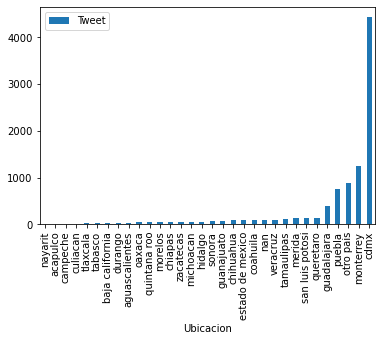

In [ ]:
estados = pd.merge(pd.DataFrame(dic_users_1.values(), columns=['Ubicacion']), est, on='Ubicacion')
estados = estados.sort_values(by='Tweet')
estados.plot.bar(x='Ubicacion',y='Tweet')

Para mostrar los tweets que tienen una ubicación totalmente diferente, realizamos la diferencia de $\sum_{i=1}^n twtm_i - \sum_{j=1}^m tw\_ubi_j$ donde *twtm* corresponden a los totales y *twt* corresponde a los tweets con ubicación

In [ ]:
est['Nombre de usuario'].sum()-estados['Nombre de usuario'].sum()

883

Dicho resultado depende de cómo haya aplicado los diccionarios sobre el DataFrame original. Se realiza la busqueda de ubicaciones que no pertenezcan a los valores de cualquiera de los diccionarios:

In [ ]:
tw_ubi = analisis.tweets_ubi_desc(tw_tm, dic_users_1)

Sustituimos caracteres especiales, acentos, etc y realizamos la busqueda de ubicaciones en los tweets.

In [ ]:
tw_ubi['Tweet'] = analisis.eliminacion_caracteres(tw_ubi['Tweet'])

temp = tw_ubi

temp['Ubicacion'] = 'nan'

tw_ubi = analisis.sustitucion_contenido(tw_ubi)

tw_ubi['Tweet'],tw_ubi['Nombre de usuario'], tw_ubi['Nombre'] = pd.DataFrame(temp[temp['Ubicacion'].str.contains(r'nan')==True]['Tweet']),pd.DataFrame(tw_tm[tw_tm['Ubicacion'].str.contains(r'nan')==True]['Nombre de usuario']),pd.DataFrame(temp[temp['Ubicacion'].str.contains(r'nan')==True]['Nombre'])

C:\Users\resen\AppData\Local\Temp\ipykernel_10540\2860461302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tw_ubi['Tweet'] = analisis.eliminacion_caracteres(tw_ubi['Tweet'])
C:\Users\resen\AppData\Local\Temp\ipykernel_10540\2860461302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Ubicacion'] = 'nan'
C:\Users\resen\AppData\Local\Temp\ipykernel_10540\3978677751.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

Debido a que aún sobran bastantes usuarios con ubicación, aplicamos la busqueda de tweets y sustitución de ubicación basándose en **dic_users_3**, de tal forma que obtenemos lo siguiente:

In [ ]:
usuarios_nan2 = analisis.busqueda_tweets_user(tw_ubi,tw_tm)

C:\Users\resen\AppData\Local\Temp\ipykernel_10540\3978677751.py:100: FutureWarning: content is deprecated, use rawContent instead
  usuarios_nan.append([tweet.user.username,tweet.content])


Eliminamos caracteres y aplicamos REGEX correspondientes a **dic_users_3**

In [ ]:
usuarios_nan2['Tweets'] = analisis.eliminacion_caracteres(usuarios_nan2['Tweets'])

usuarios_nan2 = analisis.sustitucion_tweets_users(usuarios_nan2,pd.DataFrame(usuarios_nan2['Tweets']), dic_users_3)

Sustituimos en el DataFrame **tw_tm**, de tal forma que obtenemos:

In [ ]:
tw_tm = analisis.sustitucion_tweets_nan(tw_tm,usuarios_nan2)

Cuenta por estados

In [ ]:
est = tw_tm.groupby('Ubicacion').count()

<AxesSubplot:xlabel='Ubicacion'>

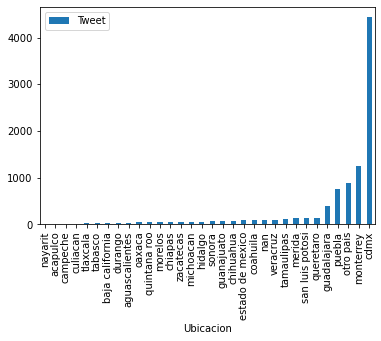

In [ ]:
estados = pd.merge(pd.DataFrame(dic_users_1.values(), columns=['Ubicacion']), est, on='Ubicacion')
estados = estados.sort_values(by='Tweet')
estados.plot.bar(x='Ubicacion',y='Tweet')

En general no se espera que cambie mucho, por lo tanto, retiramos aquellos tweets que la ubicación no esté dentro de los valores del diccionario **dic_users_3**

In [ ]:
tw_tm = analisis.df_final(tw_tm, dic_users_3)

Con esto tenemos una base de datos limpia y completa de información, con información veráz y correcta, del análisis realizado al inicio, repetimos los valores gráficos y tenemos lo siguiente:

,Tweet p/dia,Tweet p/dia banorte
Fecha,,
2021-06-01,25,24
2021-06-02,17,17
2021-06-03,36,28
2021-06-04,28,25
2021-06-07,32,55
...,...,...
2022-05-25,35,37
2022-05-26,27,17
2022-05-27,46,26


<Figure size 3200x1600 with 0 Axes>

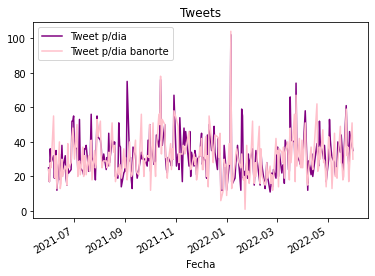

In [ ]:
analisis.dias_ts(tw_tm,banorte_tweets)

Tal como observamos, la gráfica de tweets totales no cambia mucho a la original, sin embargo, la información de los estados es totalmente distinta, lo cual nos servirá para tener una noción de los tópicos más importantes por estados y/o países.

### Análisis de sentimientos

#### Variables

Se definen las variables globales, diccionarios, clases, funciones usadas para el análisis de sentimientos.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
class sent_analysis():
   def __init__(self,tw_tm):
       self.tweets = tw_tm
   def clasification(self):
       self.tweets['pos'] = 0
       self.tweets['neu'] = 0
       self.tweets['neg'] = 0
       self.tweets['compound'] = 0
       
       for i in self.tweets['Nombre de usuario'].index:
           print(analyzer.polarity_scores(self.tweets['Tweet'][i]))

#### Clasificador de sentimientos

In [ ]:
sentiment = sent_analysis(tw_tm)

Para realizar un análisis de sentimientos, nuestro set de datos, como se mencionó anteriormente, es **tw_tm**, se tiene que realizar un entrenamiento de sentimiento sobre los tweets. Usualmente se suele realizar un entrenamiento sobre dichos documentos, sin embargo, en este caso en especial, los tweets pueden ir variando, siento que se tomó una muestra de tweets de un lapso de tiempo. En caso que se realizara dicho entrenamiento, se tendría que realizar manualmente cada que se cambie dicho lapso de tiempo. Por tanto, se propone una paquetería que realiza dicha clasificación de sentimientos, llamada **vader sentiment** 

In [ ]:
pip install vader-multi

Note: you may need to restart the kernel to use updated packages.


Es importante señalar que **vaderSentiment** es usualmente usado con palabras/oraciones en inglés, sin embargo, la paquetería **vader-multi** permite realizar una clasificación 

De forma de ejemplo, se proporciona la siguiente oración y sus respectivos resultados, donde
- neg = negativo (valor que representa la respuesta negativa)
- neu = neutral (valor que representa la respuesta neutral)
- pos = positivo (valor que representa la respuesta positiva)
- compound = compuesto (es un valor compuesto por un promedio de los resultados anteriores)

In [ ]:
analyzer.polarity_scores("¡¡¡VADER es MUY INTELIGENTE, guapo y DIVERTIDO!!!")

{'neg': 0.0, 'neu': 0.228, 'pos': 0.772, 'compound': 0.9387}

Se procede a realizar una iteración sobre todos los tweets pertenecientes a la columna **tw_tm['Tweet']** asignándole los valores retornados a una columna del sentimiento, a pesar que solo se utilizará la columna de **compound** para decidir el sentimiento *positivo*, *neutro* o *negativo*.

In [ ]:
sentiment.clasification()

@BanorteEscucha No me han atendido por MD, tiene más de una hora
¡Hola @Banorte_mx @BanorteEscucha ! Desde ayer no puedo hacer transferencias entre mis cuentas ¿ahí qué o qué o por qué?
@RockndRollas @BanorteEscucha Igual
@BanorteEscucha Ya lo envíe
@Banorte_mx @BanorteEscucha Banorte el Banco más lento de Mexico
@BanorteEscucha Gracias
@Banorte_mx @BanorteEscucha Estoy esperando una resolución tengo folio ya pasó una semana y NADIE DA SOLUCIÓN 8004403434 y me dicen que les permita en línea Solo requiero una Copia de un Testimonio de Cancelación, que ya se pago. Pero no han podido 8 días y nadie sabe nada 🤬
@BanorteEscucha tramité una TC con ustedes x internet la semana pasada, fue autorizada y supuestamente me la enviarían a mi domicilio el día de ayer y no llegó, me la enviarán o no?
@BanorteEscucha Hola!! los horarios de sucursal cuáles son ?
@alejandro0830 @BanorteEscucha @Banorte_mx Hace meses tuve 3 días así y resulta que era una actualización de la app. Eliminala y vuelve a desc

### Modelaje de tópicos (LDA)